In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load the dataset

In [2]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
df= pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", names = columns)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.shape

(1600000, 6)

Sampling the dataset

In [4]:
df_sampled = df.groupby('sentiment')[['sentiment', 'text']].sample(n=50000, random_state=1)
df_sampled.reset_index(inplace=True)
df_sampled

,index,sentiment,text
0,670935,0,"@TheRealScarab PA system bugs are a bummer, so..."
1,649589,0,oh daaamnnn! the firemen ball's on the 14th an...
2,2028,0,"I don't want to be cold in April, but I am"
3,669856,0,@JaredOngie haha its too cold down here bt ot...
4,458897,0,Upset I can't find my CHI!
...,...,...,...
99995,1006064,4,Off in a bit to meet Spuds new family at his f...
99996,1497567,4,watching videos in youtube about Drake Bell..
99997,1506693,4,who wants to go to the laker parade with me
99998,1061627,4,@BELAI83 i'm great!!!hang out but i have to co...


<Axes: xlabel='sentiment'>

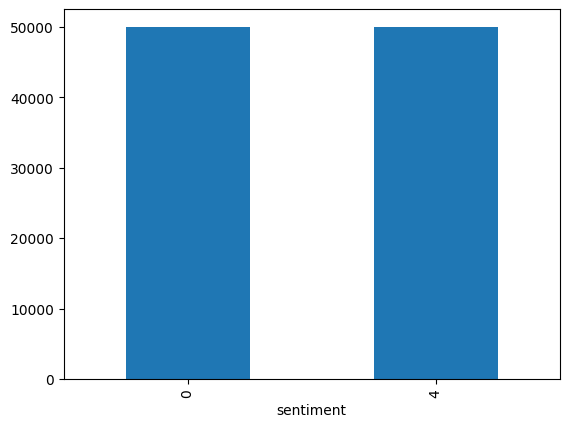

In [5]:
df_sampled.groupby(['sentiment']).size().plot(kind='bar')

In [6]:
df_sampled.isnull().sum()

index        0
sentiment    0
text         0
dtype: int64

WordCloud

In [7]:
!pip install wordcloud

In [8]:
# from wordcloud import WordCloud
# plt.figure(figsize=(20, 10))

# # Combine all text entries from the 'text' column of your dataframe into a single string
# text_combined = " ".join(cat for cat in df_sampled.text)
# word_cloud = WordCloud(
#     collocations=False, 
#     background_color='white', 
#     width=2000, 
#     height=1000
# ).generate(text_combined)

# # Display the generated Word Cloud
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis("off")  # Turn off the axis numbers and labels
# plt.show()  # Display the plot

Preprocessing 

1. Lower case
2. Removing urls
3. Removing usernames
4. Replace emojis
5. Remove the chat words and numbers(e.g lol to laugh out loud , 1 to one)
6. replace contractions
7. Remove punctuations
8. Lemmatization and replace consecutive letters
9. Remove stopwords

In [9]:
from num2words import num2words
slangDf = pd.read_csv("slang.csv")
slangDf=slangDf[['acronym','expansion']]
slangDf.head()


,acronym,expansion
0,2day,today
1,2m2h,too much too handle
2,2moro,tomorrow
3,2nite,tonight
4,4eae,for ever and ever


In [10]:
def replace_chat_words(text):
    normal_word=slangDf[slangDf['acronym'].isin([text])]['expansion'].values
    if len(normal_word)>=1:
        if text=='lol':
            return normal_word[1]
        else:
            return normal_word[0]
    elif text.isnumeric():
        return num2words(text)
    else:
        return text
    
replace_chat_words('lol')

'laughing out loud'

In [11]:
import re
import emoji
import contractions as con
import string
import en_core_web_lg
# pip install spacy
# python -m spacy download en_core_web_lg
from autocorrect import Speller

nlp=en_core_web_lg.load()
speller=Speller(lang='en')
stop_words=nlp.Defaults.stop_words

def preprocessingText(text):
  text = text.lower()
  # Remove urls
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  # # Remove usernames
  text = re.sub(r'@[^\s]+','', text)
  # # Replace all emojis from the emoji shortcodes
  text = emoji.demojize(text)
  # # Replace chat words and numbers
  text = " ".join([replace_chat_words(word) for word in text.split()])
  # Replace contraction words
  text=con.fix(text)
  # Remove punctuations
  text = "".join([i for i in text if i not in string.punctuation])
  # Replace 3 or more consecutive letters by 1 letter and lemmatizing the words
  text = " ".join([re.sub(r"(.)\1\1+", r"\1", str(token)) if token.pos_ in ["PROPN", 'NOUN'] else token.lemma_ for token in nlp(text)])
  # Replace misspelled words
  text=speller(text)
  # Remove stopwords
  text = " ".join([word for word in text.split() if word not in stop_words])

  text = text.strip()

  return text


In [12]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext,Row 

conf=SparkConf()
sc=SparkContext(conf=conf)
sqlContext=SQLContext(sc)


23/11/15 19:18:54 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.234.128 instead (on interface ens33)
23/11/15 19:18:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/11/15 19:18:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [13]:
df=sqlContext.read.csv('training.1600000.processed.noemoticon.csv',header=True)
df=df.rdd
df=df.map(lambda x:(x[0],x[5]))
df_processed=df.map(lambda x:(x[0],preprocessingText(x[1])))
df_processed.take(5)

[('0',
  'upset happy end high explosives update facebook texte cry result school today blah'),
 ('0', 'I dive times ball manage time save 50 rest bounds'),
 ('0', 'miss body feel itch like I think think fire'),
 ('0', 'behave I mad ante meridian amplitude modulation I I'),
 ('0', 'crew')]

In [14]:
from pyspark.sql.types import StructField, StructType, StringType,IntegerType
schema = StructType([
        StructField("sentiment", StringType(), True),
        StructField("text", StringType(), True)
    ])
df_processed=sqlContext.createDataFrame(df_processed,schema)

In [16]:
df_processed=df_processed.toPandas()